In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.datasets import MNIST
from torchvision.models import resnet18
from torchvision.transforms import *
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
import itertools
import os
import sys
sys.path.append("..")
from vos import VOS

# Load data, set up problem

In [2]:
dataset = MNIST(root = "~/datasets/MNIST", train = True)
transform = Compose([lambda x: x.float(), Normalize((0.1307,), (0.3081,))])

samples = dataset.data
targets = dataset.targets
data = TensorDataset(transform(samples).unsqueeze(1), targets)

loader = DataLoader(data, batch_size = 1024)

In [3]:
data_dict = {key:[] for key in dataset.targets.unique().tolist()}
for batch in loader:
    x, y = batch
    for pair in zip(x, y):
        x, y = pair
        data_dict[y.item()].append(x)

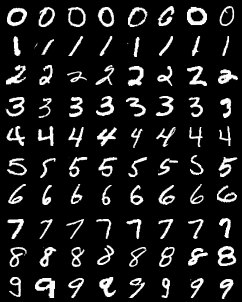

In [4]:
images = [random.sample(data_dict[key], 8) for key in np.sort(list(data_dict.keys()))]
images = torch.stack(list(itertools.chain.from_iterable(images)))
grid = make_grid(images, nrow = 8, normalize = True)

img = ToPILImage()(grid)
img

In [5]:
backbone = resnet18()
backbone.conv1 = nn.Conv2d(1, 64, kernel_size = (7, 7), stride = (2, 2), padding = (3, 3), bias = False)
backbone.fc = nn.Linear(512, 10)
for module in backbone.modules():
    if type(module) == nn.BatchNorm2d:
        module.track_running_stats = False

In [6]:
class OODDetector(nn.Module):
    def __init__(self, latent_dim = 512):
        super().__init__()
        self.latent_dim = latent_dim
        self.mlp = nn.Sequential(nn.Linear(1, latent_dim),
                                 nn.ReLU(),
                                 nn.Linear(latent_dim, 1))
    
    def forward(self, x):
        out = self.mlp(x)
        return out
    
ood_detector = OODDetector(latent_dim = 512)

# Optional model pretraining

In [7]:
pretrain = False
if pretrain:
    criterion = nn.CrossEntropyLoss()
    opt = Adam(backbone.parameters(), lr = 1e-3)
    lr_scheduler = ReduceLROnPlateau(opt, factor = 0.5)
    print(f"CUDA is {torch.cuda.is_available()}")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    backbone.to(device)

    epochs = 100
    for epoch in range(epochs):
        running_loss = 0.
        iteration_counter = 0
        for batch in loader:
            samples, targets = batch
            samples, targets = samples.to(device), targets.to(device)

            opt.zero_grad()

            outputs = backbone(samples)

            loss = criterion(outputs, F.one_hot(targets).float())
            loss.backward()

            opt.step()

            running_loss += loss
            iteration_counter += 1
        
        if epoch % 10 == 9:
            print(f"Epoch: {epoch + 1}")
            print(f"Loss: {running_loss/iteration_counter}")

    backbone.to("cpu")
    torch.save(backbone, "../model_weights/pretrained_model.pt")
else:
    backbone = torch.load("../model_weights/pretrained_model.pt", weights_only = False)

# Set up VOS

In [8]:
vos = VOS(backbone, ood_detector, data, queue_size = 1024)

# Data visualizations

In [9]:
target = 0
mode = vos.class_conditional_modes[target]
id_samples = torch.stack(vos.queue[target]).to(vos.device)

latents = vos.stripped_backbone(id_samples).squeeze().detach()
id_likelihoods = vos.compute_gmm_log_likelihood(latents, target)

In [10]:
vos.sample_ood()
ood_samples = vos.ood_queue[target]
ood_likelihoods = vos.compute_gmm_log_likelihood(ood_samples, target)

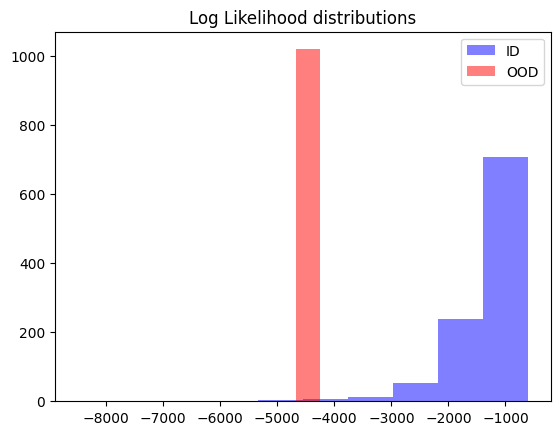

In [11]:
plt.hist(id_likelihoods.cpu(), color = "blue", label = "ID", alpha = 0.5)
plt.hist(ood_likelihoods.cpu(), color = "red", label = "OOD", alpha = 0.5)
plt.title("Log Likelihood distributions")
plt.legend()
plt.show()

# Train VOS

In [12]:
vos.train(iterations = 100, lr = 1e-3, beta = 0.1)

Iteration: 0
Classification Loss: 8.909737516660243e-07
Uncertainty Loss: 2.623805522918701
Iteration: 1
Classification Loss: 9.033954120241106e-05
Uncertainty Loss: 2.336423635482788
Iteration: 2
Classification Loss: 0.0029068475123494864
Uncertainty Loss: 1.5567888021469116
Iteration: 3
Classification Loss: 0.0004278006963431835
Uncertainty Loss: 1.70427405834198
Iteration: 4
Classification Loss: 0.005123191978782415
Uncertainty Loss: 1.4563417434692383
Iteration: 5
Classification Loss: 0.00020075585052836686
Uncertainty Loss: 1.5320234298706055
Iteration: 6
Classification Loss: 0.004216859582811594
Uncertainty Loss: 1.3525351285934448
Iteration: 7
Classification Loss: 0.0030492970254272223
Uncertainty Loss: 1.4119294881820679
Iteration: 8
Classification Loss: 0.0011669063242152333
Uncertainty Loss: 1.327331781387329
Iteration: 9
Classification Loss: 0.0012253166642040014
Uncertainty Loss: 1.3211021423339844
Iteration: 10
Classification Loss: 0.0007199335377663374
Uncertainty Loss: 1

# Save model

In [13]:
torch.save(vos.backbone, "../model_weights/vos_model.pt")

In [14]:
torch.save(vos.ood_detector, "../model_weights/vos_ood_detector.pt")

In [15]:
vos.uncertainty_loss()

tensor(0.0499, device='cuda:0', grad_fn=<AddBackward0>)

# Demonstrate some post-training metrics on synthesized data

In [16]:
test_dataset = MNIST(root = "~/datasets/MNIST", train = False)
transform = Compose([lambda x: x.float(), Normalize((0.1307,), (0.3081,))])

test_samples = test_dataset.data
test_targets = test_dataset.targets
test_data = TensorDataset(transform(test_samples).unsqueeze(1), test_targets)

test_loader = DataLoader(test_data, batch_size = 10240, shuffle = True)

In [17]:
id_samples = next(iter(test_loader))[0].to(vos.device)

id_logits = vos.backbone(id_samples)

ood_latents = torch.tensor([],device = vos.device)
for key in vos.ood_queue.keys():
    new_ood_latents = vos.ood_queue[key]
    ood_latents = torch.cat((ood_latents, new_ood_latents))
classifier = list(vos.backbone.children())[-1]
ood_logits = classifier(ood_latents)

id_energies, ood_energies = vos.free_energy(id_logits), vos.free_energy(ood_logits)
id_energy_surface, ood_energy_surface = vos.ood_detector(id_energies), vos.ood_detector(ood_energies)

# At the end of training, we want one group to be positive, one group to be negative

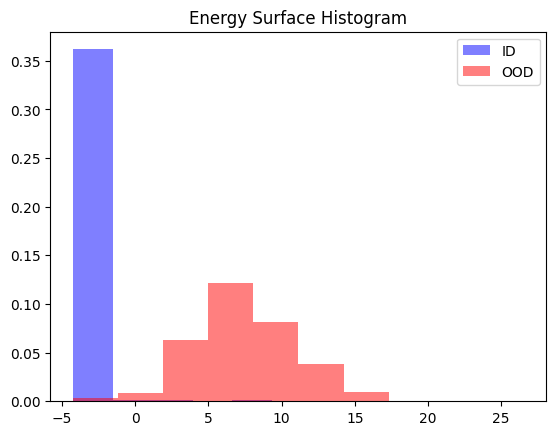

In [18]:
plt.hist(id_energy_surface.cpu().detach().flatten(), color = 'blue',
                                                     alpha = 0.5, 
                                                     label = "ID",
                                                     density = True)
plt.hist(ood_energy_surface.cpu().detach().flatten(), color = 'red', 
                                                     alpha = 0.5, 
                                                     label = "OOD", 
                                                     density = True)
plt.title("Energy Surface Histogram")
plt.legend()
plt.show()

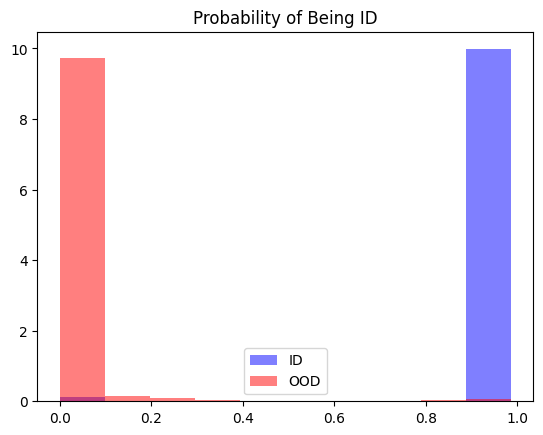

In [19]:
prob_id_is_id = torch.exp(-id_energy_surface)/(1 + torch.exp(-id_energy_surface))
prob_ood_is_id = torch.exp(-ood_energy_surface)/(1 + torch.exp(-ood_energy_surface))
prob_id_is_id = prob_id_is_id.detach().flatten().cpu()
prob_ood_is_id = prob_ood_is_id.detach().flatten().cpu()
plt.hist(prob_id_is_id, color = "blue", label = "ID", alpha = 0.5, density = True)
plt.hist(prob_ood_is_id, color = "red", label = "OOD", alpha = 0.5, density = True)
plt.title("Probability of Being ID")
plt.legend()
plt.show()

In [20]:
allowable_id_error = 0.05 # 5 percent of ID data can be misclassified (following paper)
threshold = sorted(prob_id_is_id)[int(allowable_id_error*len(prob_id_is_id))]
print(f"Detection Threshold: {threshold}")

Detection Threshold: 0.9827667474746704


In [21]:
id_detected_as_ood = [1 if prob < threshold else 0 for prob in prob_id_is_id.detach().flatten()]
id_detection_fpr = sum(id_detected_as_ood)/len(id_detected_as_ood)
print(f"False Positive Rate (ID detected as OOD): {id_detection_fpr}")

False Positive Rate (ID detected as OOD): 0.05
